# Classification

Note book to view classification results.

First import libraries

In [2]:
from decouple import config
import os
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from nilearn import datasets, plotting, image 
from fNeuro.connectivity.connectivity import Cyclic_analysis, connectome_plotting, cyclic_order, get_correlation_long_df, get_mean_correlation_matrix
from fNeuro.connectivity.organise_networks import order_networks
import fNeuro.processing.processing as processing
from fNeuro.bayesian.bayesian import z_score_to_bayes_factor, logistic_to_bayes_factor 
from fNeuro.utils.pickling import load_pickle
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Get time series 

In [3]:
resting_path = config('resting')
time_series = load_pickle(os.path.join(resting_path, 'measures', 'time_series'))
an_time_series = list(time_series['an'].values())
hc_time_series = list(time_series['hc'].values())
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })

Concat time series into one array and build labels. 0 is AN, 1 is HC

In [4]:
group = np.asarray(an_time_series + hc_time_series)
label = np.asarray([0 for sub in range(len(an_time_series))] + [1 for sub in range(len(hc_time_series))])

Plot an example of a time series

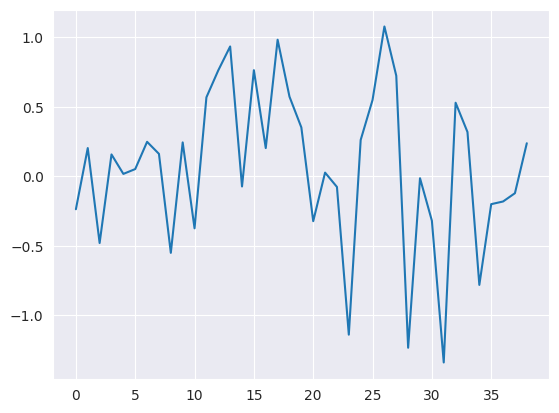

In [5]:
plt.plot(an_time_series[0][3])
plt.show()

## Get the most accurate model

Load in the models from memory

In [6]:
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
svc = load_pickle(os.path.join(resting_path, 'measures', 'svc_model'))
logistic = load_pickle(os.path.join(resting_path, 'measures', 'logistic_model'))
random_forest = load_pickle(os.path.join(resting_path, 'measures', 'random_forest_model'))
dec_tree = load_pickle(os.path.join(resting_path, 'measures', 'tree_model'))
stacked = load_pickle(os.path.join(resting_path, 'measures', 'stacked_model'))

Plot the accuracy of all  ml models

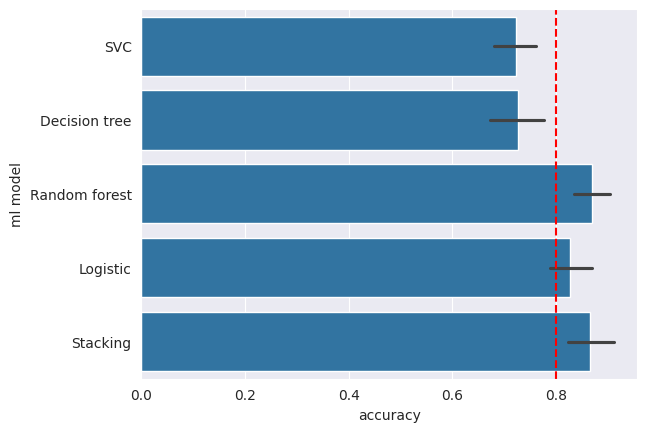

In [7]:
overal_score = {'Accuracy': pd.DataFrame(data={
                                                'SVC': svc['Accuracy'],
                                                'Decision tree': dec_tree['Accuracy'],
                                                'Random forest': random_forest['Accuracy'],
                                                'Logistic': logistic['Accuracy'],
                                                'Stacking': stacked['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                                'SVC': svc['ROC_AUC'],
                                                'Decision tree': dec_tree['ROC_AUC'],
                                                'Random forest': random_forest['ROC_AUC'],
                                                'Logistic': logistic['ROC_AUC'], 
                                                'Stacking': stacked['ROC_AUC']
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(overal_score['Accuracy']).rename(columns={'variable': 'ml model', 'value': 'accuracy'}), 
                   x='accuracy', y='ml model')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

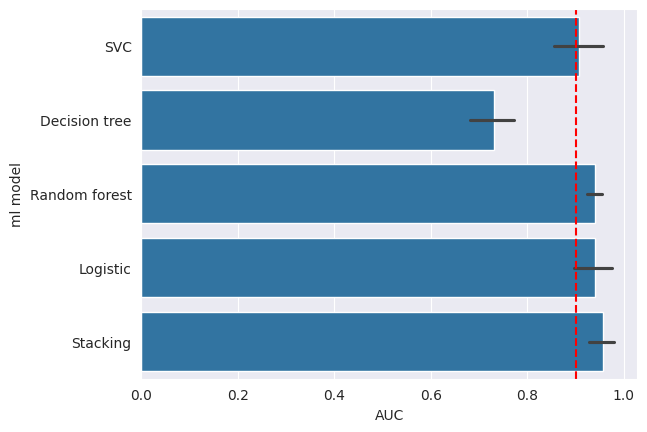

In [8]:
auc = sns.barplot(data=pd.melt(overal_score['AUC']).rename(columns={'variable': 'ml model', 'value': 'AUC'}), 
                   x='AUC', y='ml model')
auc.axvline(0.9, color="red", linestyle="--")

In [9]:
overal_score['Accuracy'].mean()

SVC              0.723077
Decision tree    0.726923
Random forest    0.869231
Logistic         0.826923
Stacking         0.865385
dtype: float64

In [10]:
overal_score['AUC'].mean()

SVC              0.907692
Decision tree    0.730769
Random forest    0.940237
Logistic         0.940237
Stacking         0.956805
dtype: float64

### Comparing cyclic analysis to other connectivity analysis

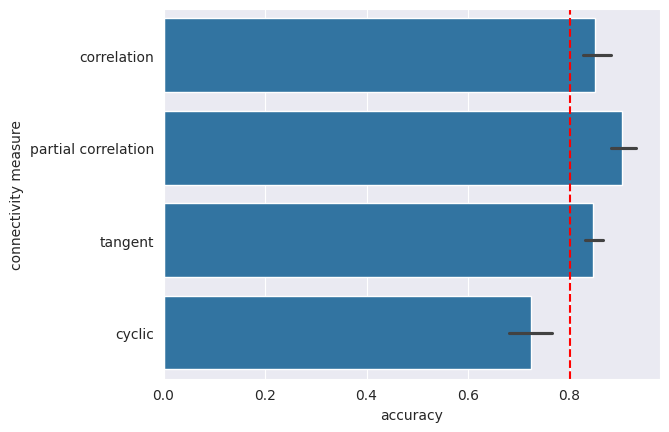

In [11]:
comp_scores = load_pickle(os.path.join(resting_path, 'measures', 'svc_comparison'))
del(comp_scores['cyclic']['model'])
comp_score_dict = {'Accuracy': pd.DataFrame(data={
                                                'correlation': comp_scores['correlation'][0]['Accuracy'],
                                                'partial correlation': comp_scores['partial correlation'][0]['Accuracy'],
                                                'tangent': comp_scores['tangent'][0]['Accuracy'],
                                                'cyclic': comp_scores['cyclic']['Accuracy'],
                                                }),
                'AUC': pd.DataFrame(data={
                                            'correlation': comp_scores['correlation'][0]['ROC_AUC'],
                                            'partial correlation': comp_scores['partial correlation'][0]['ROC_AUC'],
                                            'tangent': comp_scores['tangent'][0]['ROC_AUC'],
                                            'cyclic': comp_scores['cyclic']['ROC_AUC'],
                                                })
}

accuracy_plot = sns.barplot(data=pd.melt(comp_score_dict['Accuracy']).rename(columns={'variable': 'connectivity measure', 'value': 'accuracy'}), 
                   x='accuracy', y='connectivity measure')
accuracy_plot.axvline(0.8, color="red", linestyle="--")

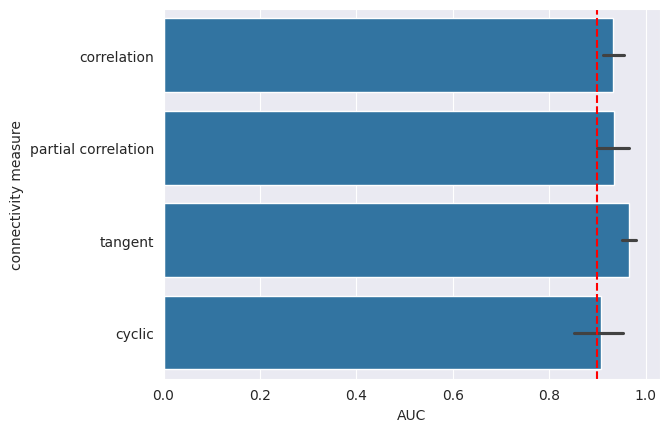

In [12]:
auc = sns.barplot(data=pd.melt(comp_score_dict['AUC']).rename(columns={'variable': 'connectivity measure', 'value': 'AUC'}), 
                   x='AUC', y='connectivity measure')
auc.axvline(0.9, color="red", linestyle="--")

### Examine weights and correlations

First get the full correlation matrix then get the mean correlations of group. Get the names of all the correlations and finally get the mean correlation values 

In [13]:
correlation_matrix = get_mean_correlation_matrix(group, msdl['labels'])
an_mean_correlations = correlation_matrix['an_mean_correlations']
hc_mean_correlations = correlation_matrix['hc_mean_correlations']

Get the correlation names, network names and values by group 

In [14]:
an_df = get_correlation_long_df(an_mean_correlations, msdl_overview_df)
hc_df = get_correlation_long_df(hc_mean_correlations, msdl_overview_df)

Get the biomarker information

In [15]:
markers_df = pd.DataFrame(data={
                            'correlation_names': an_df['corr_names'],
                            'network': an_df['network_names'],
                            'rf_importance': stacked['model'].named_estimators_.rf.feature_importances_,
                              })
markers_df['log_coeffiecents'] = stacked['model'].named_estimators_.log.coef_.T
markers_df['Bayes'] = markers_df['log_coeffiecents'].apply(lambda coef: logistic_to_bayes_factor(coef))

Segregate the biomarker dataframe by network and calculate the mean of each network and get the value for all between network nodes

In [16]:
network_values = order_networks(msdl_overview_df, markers_df, 'network')
within_network = dict(zip([network for network in msdl_overview_df['networks'].unique()], 
                          [{} for network in msdl_overview_df['networks'].unique()]))
for get_mean in network_values.keys():
    if len(network_values[get_mean]['within']) > 0:
        within_network[get_mean]['rf_importance'] = network_values[get_mean]['within']['rf_importance'].mean()
        within_network[get_mean]['log_coeffiecents'] = network_values[get_mean]['within']['log_coeffiecents'].mean()

between_network_list  =[network_values[df]['between'] for df in network_values.keys()]
between_network = pd.concat(between_network_list).reset_index(drop=True)

Get the most predicitive network

In [17]:
within_network_df = pd.DataFrame(within_network).T.dropna()
within_network_df = processing.df_with_transformed_values(within_network_df)
most_predicitive_within_network = processing.get_max_value(within_network_df)
most_predicitive_within_network['an_corr'] = an_df[an_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network['hc_corr'] = hc_df[hc_df['network_names'].str.contains(f'{most_predicitive_within_network.index[0]} - {most_predicitive_within_network.index[0]}')]['correlation'].mean()
most_predicitive_within_network['bayes_factor'] = most_predicitive_within_network['z_score_transformation_rf'].apply(lambda bayes: z_score_to_bayes_factor(bayes))
most_predicitive_within_network

,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr,bayes_factor
Temporal,0.004519,-0.009828,2.830189,-1.856156,0.79022,-2.372246,54.87093


Within the most predicitive network nodes connection (Sometimes there is only hence why bayes factor is not calculated as z scores will be 0)

In [18]:
within_network_prediction = network_values[most_predicitive_within_network.index[0]]['within']
within_network_prediction = processing.df_with_transformed_values(within_network_prediction)
most_predicitive_within_network_node = processing.get_max_value(within_network_prediction)
most_predicitive_within_network_node['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_within_network_node['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_within_network_node

,correlation_names,network,rf_importance,log_coeffiecents,Bayes,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr
350,R STS - L STS,Temporal - Temporal,0.004519,-0.009828,1.000048,0.0,0.0,0.79022,-2.372246


Get the most predicitive between network connectivity nodes

In [19]:
between_network_df = processing.df_with_transformed_values(between_network)
most_predicitive_between_network = processing.get_max_value(between_network_df)
most_predicitive_between_network['an_corr'] = an_df[an_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network['hc_corr'] = hc_df[hc_df['corr_names'] == most_predicitive_between_network['correlation_names'].values[0]]['correlation'].values[0]
most_predicitive_between_network['bayes_factor'] = most_predicitive_between_network['z_score_transformation_rf'].apply(lambda bayes: z_score_to_bayes_factor(bayes))
most_predicitive_between_network.drop('Bayes', axis=1)

,correlation_names,network,rf_importance,log_coeffiecents,z_score_transformation_rf,z_score_transformation_log,an_corr,hc_corr,bayes_factor
132,L IPS - R Post Temp,D Att - R V Att,0.025372,-0.022956,11.447146,-2.263383,1.597211,-5.70791,2.846784e+28


## Plot connectomes

The logistic coeffiecents are plotted for ease of visualisation 

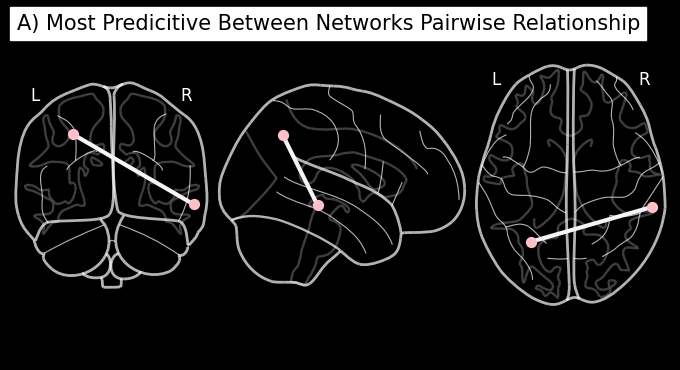

In [20]:
plot_parameters = connectome_plotting(most_predicitive_between_network, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='A) Most Predictive Between Networks Pairwise Relationship')

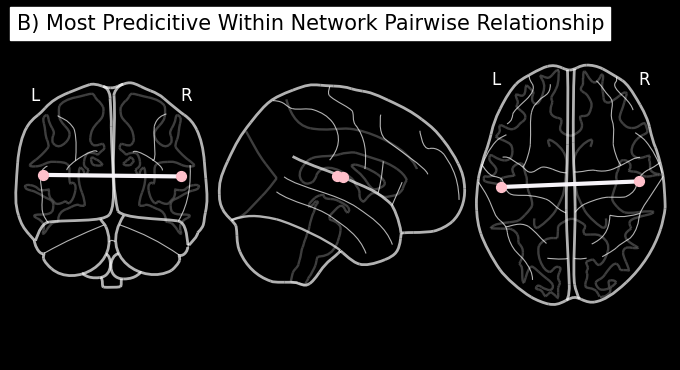

In [21]:
plot_parameters = connectome_plotting(most_predicitive_within_network_node, 'log_coeffiecents', msdl_overview_df)
plotting.plot_connectome(plot_parameters['adj'], 
                         plot_parameters['coords'],   
                         node_color='pink',
                         node_size=50,
                         edge_cmap='PuRd',
                         black_bg=True, 
                         title='B) Most Predictive Within Network Pairwise Relationship')

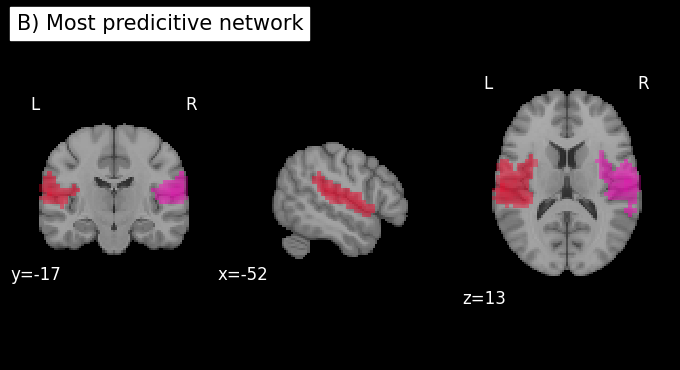

In [61]:
plotting.plot_prob_atlas(
    image.index_img(
        msdl['maps'], 
        msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])].index.to_list()
        ),
    draw_cross=False,
    black_bg=True,
    cut_coords=msdl_overview_df[msdl_overview_df['networks'].str.contains(most_predicitive_within_network.index[0])]['region_coords'].to_list()[0],
    cmap='gist_rainbow',
    title='B) Most Predictive network'
)


Sort out the AN and HC correlations into one DataFrame 

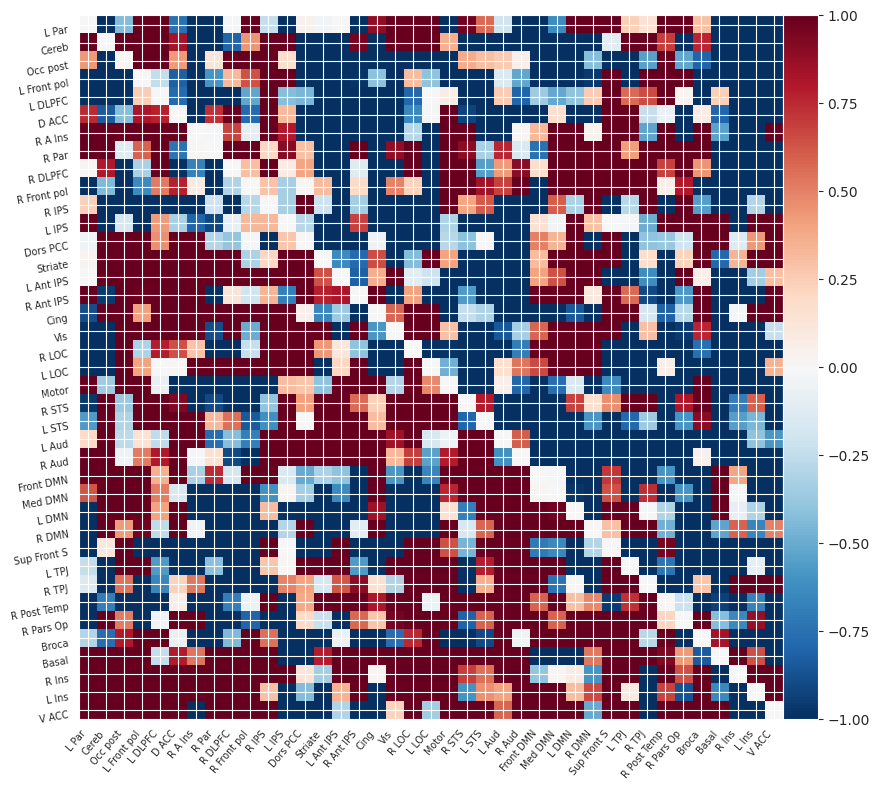

In [23]:
plotting.plot_matrix(
    an_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

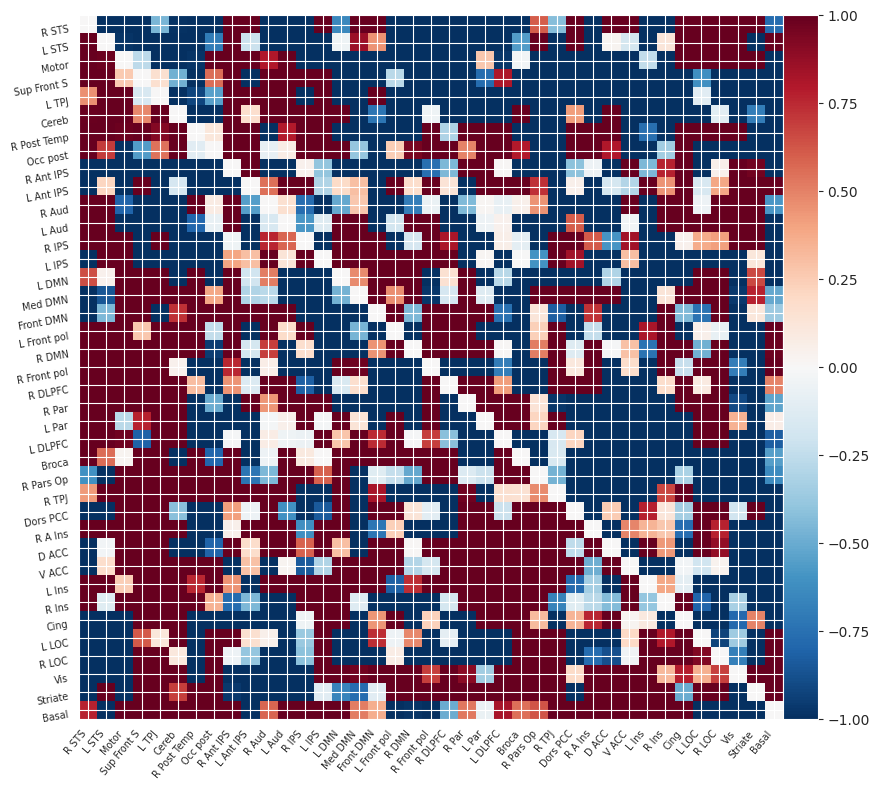

In [24]:
plotting.plot_matrix(
    hc_mean_correlations.values,
    figure=(10, 8),
    labels=msdl['labels'],
    vmax=1,
    vmin=-1,
    reorder=True,
)

Plot the AN and HC connectomes

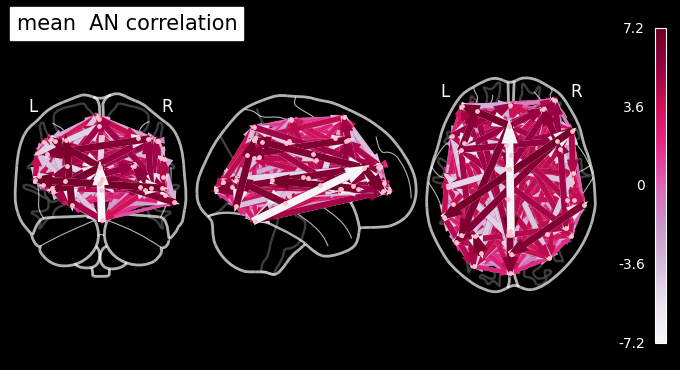

In [25]:
plotting.plot_connectome(
    an_mean_correlations.values,
    msdl['region_coords'],
    title="mean  AN correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='PuRd',
    black_bg=True,
    colorbar=True
)

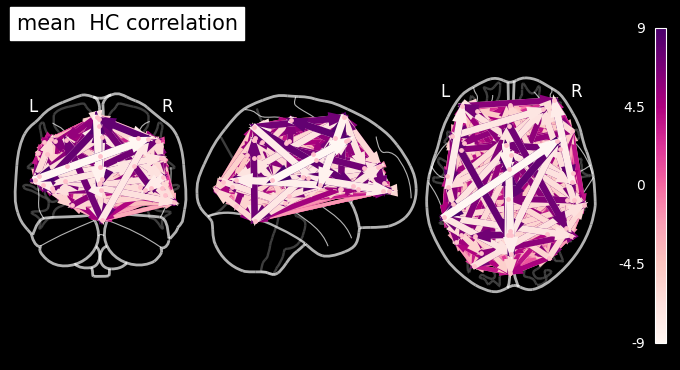

In [26]:
plotting.plot_connectome(
    hc_mean_correlations.values,
    msdl['region_coords'],
    title="mean  HC correlation",
    node_color='pink',
    node_size=6,
    edge_cmap='RdPu',
    black_bg=True,
    colorbar=True
)